In [844]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin
from sklearn.linear_model import LinearRegression

# Figure 3

In [12]:
pd.options.display.max_columns = 999

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [843]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_lin = "../svg/panel_b_lin.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"
PANEL_supp_shift7 = "../svg/panel_supp_shift7.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

PANEL_NEW_A = "../svg/panel_new_a_inkscape.svg"

PANEL_NEW_F1 = "../svg/panel_new_f1.svg"
PANEL_NEW_F2 = "../svg/panel_new_f2.svg"

PANEL_NEW_G1 = "../svg/panel_new_g1.svg"
PANEL_NEW_G2 = "../svg/panel_new_g2.svg"
PANEL_NEW_supp_params_11 = "../svg/PANEL_NEW_supp_params_11.svg"
PANEL_NEW_supp_params_12 = "../svg/PANEL_NEW_supp_params_12.svg"
PANEL_NEW_supp_params_21 = "../svg/PANEL_NEW_supp_params_21.svg"
PANEL_NEW_supp_params_22 = "../svg/PANEL_NEW_supp_params_22.svg"

### Load experimental data

In [15]:
prior_11 = create_prior()

In [16]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Simulate 10 samples and keep track of the energy consumption of each trace

In [528]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [533]:
# torch.manual_seed(0)
# params_with_seeds = np.concatenate(
#     (
#         theta_np[:200],
#         seeds[:200][
#             None,
#         ].T,
#     ),
#     axis=1,
# )
# simulation_outputs = list(map(simulator, params_with_seeds))
simulation_outputs = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", allow_pickle=True)

In [534]:
# np.save("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", simulation_outputs)

In [535]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [536]:
summed_energy_synapses = np.sum(all_e_syn, axis=1)

In [537]:
summed_energy_membrane = np.sum(np.sum(all_e_cur, axis=1), axis=1)

In [538]:
fraction_between_them = summed_energy_synapses / (summed_energy_membrane + summed_energy_synapses)

In [539]:
print("Fraction of energy consumed by synapses:   ", np.mean(fraction_between_them)*100, "%")

Fraction of energy consumed by synapses:    0.07815773482273314 %


In [540]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)

### Sketch of active subspace

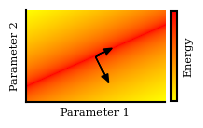

In [541]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.active_subspace_sketch()
    plt.savefig(PANEL_B_raw, facecolor='None', transparent=False)

###  Fit regression net for total energy

In [542]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [543]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [544]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1130: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [545]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [546]:
energies = x["energies"]

In [547]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [548]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [549]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [550]:
posterior._sample_with = "rejection"

In [551]:
# torch.manual_seed(0)
# sensitivity = ActiveSubspace(posterior.set_default_x(xo))
# converged_nn = sensitivity.add_property(
#     theta_train, train_energy, hidden_features=20, num_blocks=1
# ).train()
# e_vals, e_vecs = sensitivity.find_directions()

In [552]:
# predictions = converged_nn(theta_test).detach()

In [558]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
#     unnorm_x = test_energy[:300]
#     unnorm_y = predictions[:300]
#     ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y.numpy()/10/1000, s=3, color="#2b8cbe")
#     gt_vec = np.linspace(np.min(unnorm_x.numpy()/10/1000), np.max(unnorm_x.numpy()/10/1000), 2)
#     ax.plot(gt_vec, gt_vec, "#ff7f00")
#     ax.set_xlabel("Total energy ($\mu$J/s)")
#     ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance1, facecolor='None', transparent=False)

In [559]:
# unnorm_y = predictions[:300]
# mse = torch.mean(torch.abs(unnorm_x/10/1000 - unnorm_y/10/1000) ** 2)
# print("mean squared error: ", mse)

In [560]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.plot_eigenvalues(
#         torch.abs(torch.flip(e_vals, dims=(0,))),
#         figsize=(2.0, 1.0),
#         ylabel="log(E.-value)",
#         color="k",
#         title="Total energy"
#     )
#     plt.savefig(PANEL_supp_EV1, facecolor="None", transparent=False)
#     plt.show()

In [561]:
# print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

In [562]:
# print("Fraction of first to total: ", e_vals[-1] / torch.sum(e_vals))

In [563]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.py_sensitivity_bars_cosyne(
#         e_vecs[:, -1].T,
#         ylim=[-1, 1.0],
#         figsize=(2.85, 1.2),
#         ylabel='Active dir.',
#         plot_labels=True,
#         title='Total energy',
#         yticks=[-1, 0, 1]
#     )
#     plt.savefig(PANEL_C, facecolor="None", transparent=False)
#     plt.show()

In [564]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.synapse_sensitivity_bars(
#         deepcopy(e_vecs[24:, -1:].T), ylim=[-0.3, 0.6], figsize=(1.8, 1.0), ylabel="Active dir.", color="k", title='Total energy'
#     )
#     plt.savefig(PANEL_supp_synapses1, facecolor="None", transparent=False)
#     plt.show()

### Linear regression

In [664]:
num_test = 500

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [665]:
train_energy_ABPD = torch.sum(torch.as_tensor(energies.to_numpy())[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(torch.as_tensor(energies.to_numpy())[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

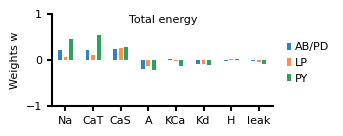

In [666]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.85, 1.2),
        ylabel='Weights w',
        plot_labels=True,
        title='Total energy',
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_C, facecolor="None", transparent=False)
    plt.show()

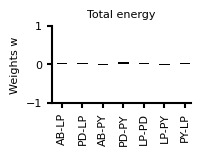

In [821]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-0.3, 0.6], figsize=(1.8, 1.0), ylabel="Weights w", color="k", title='Total energy'
    )
    plt.savefig(PANEL_supp_synapses1, facecolor="None", transparent=False)
    plt.show()

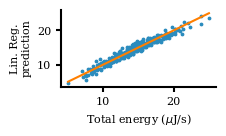

In [670]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y/10/1000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy())/10/1000, np.max(unnorm_x.numpy())/10/1000, 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Lin. Reg.\nprediction")
    plt.savefig(PANEL_supp_performance1, facecolor='None', transparent=False)

### Variance reduction plot

In [671]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

In [672]:
inds = np.argsort(summed_energies)

In [673]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
quantile = 0.02
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

In [674]:
min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

In [675]:
min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

In [676]:
from sbi.analysis import pairplot

In [677]:
from pyloric import create_prior

In [678]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T

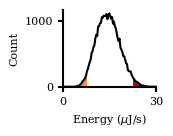

In [679]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.2, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 30])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 30], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 30], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 30])
    ax.set_xticks([0, 30])
    plt.savefig(PANEL_supp_shift1, facecolor="None", transparent=False)

In [680]:
std_of_min_energy = np.std(min_energy_theta, axis=0)
std_of_all_samples = np.std(theta_np, axis=0)

In [681]:
stds_fraction = std_of_min_energy / std_of_all_samples

In [682]:
print(stds_fraction[:8])
print(stds_fraction[8:16])
print(stds_fraction[16:24])
print(stds_fraction[24:])

[0.8037193  0.8464843  0.9300234  0.95980245 0.99449205 0.94929683
 1.0431094  1.0038784 ]
[1.044511   0.9603026  0.86817485 1.0000968  0.9569214  0.93456495
 1.020405   1.0002675 ]
[0.6696571  0.554467   0.8713912  0.9851734  0.902615   0.99208903
 0.9757338  0.8798166 ]
[0.91078734 0.9658037  0.90537155 1.1536438  0.93125415 0.9684211
 1.1299083 ]


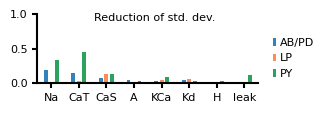

In [683]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        1.0 - deepcopy(torch.as_tensor(stds_fraction)),
        ylim=[0.0, 1.0],
        figsize=(2.85, 0.9),
        ylabel="",
        title='Reduction of std. dev.',
        title_x_offset=-0.75,
        title_y_offset=0.1
    )
    plt.savefig(PANEL_supp_shift7, facecolor="None", transparent=False)
    plt.show()

In [684]:
from stg_energy.common import get_labels_8pt

In [685]:
labels_ = get_labels_8pt()

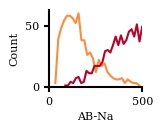

In [686]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.2, 1.0))
    ind=0
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(labels_[ind])
    ax.set_ylabel("Count")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    plt.savefig(PANEL_supp_shift2, facecolor="None", transparent=False)

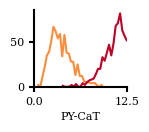

In [687]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.2, 1.0))
    ind = 17
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(labels_[ind])
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    plt.savefig(PANEL_supp_shift3, facecolor="None", transparent=False)

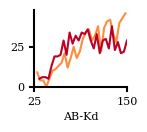

In [688]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.2, 1.0))
    ind = 5
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(labels_[ind])
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    plt.savefig(PANEL_supp_shift4, facecolor="None", transparent=False)

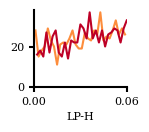

In [689]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.2, 1.0))
    ind = 14
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(labels_[ind])
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    plt.savefig(PANEL_supp_shift5, facecolor="None", transparent=False)

In [690]:
min_means = np.mean(min_energy_theta, axis=0)
max_means = np.mean(max_energy_theta, axis=0)
prior_std = prior.stddev

In [691]:
mean_shifts = max_means - min_means

In [692]:
mean_shifts_norm = mean_shifts / prior_std

In [693]:
mean_shifts_norm = mean_shifts_norm / np.linalg.norm(mean_shifts_norm)

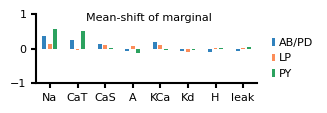

In [694]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        deepcopy(mean_shifts_norm),
        ylim=[-1, 1.0],
        figsize=(2.85, 0.9),
        ylabel="",
        title='Mean-shift of marginal',
        title_x_offset=-1.0,
    )
    plt.savefig(PANEL_supp_shift6, facecolor="None", transparent=False)
    plt.show()

## Which parameters affect energy, which parameters influence energy?

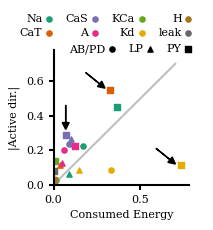

In [695]:
eigenvector = coeff[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.scatter_sensitivity_consumption(all_fractions, eigenvector)
    plt.savefig(PANEL_D, facecolor="None", transparent=False)

# Energy per spike

In [696]:
# all_energies_per_spike_ABPD = x["energies_per_spike"]["PM"].to_numpy()
# all_energies_per_spike_ABPD_test = torch.as_tensor(
#     all_energies_per_spike_ABPD[:num_test], dtype=torch.float32
# ).unsqueeze(1)
# all_energies_per_spike_ABPD_train = torch.as_tensor(
#     all_energies_per_spike_ABPD[num_test:], dtype=torch.float32
# ).unsqueeze(1)

In [697]:
# torch.manual_seed(0)

# sensitivity_e_per_spike = ActiveSubspace(posterior.set_default_x(xo))
# converged_nn_e_per_spike = sensitivity_e_per_spike.add_property(
#     theta_train, all_energies_per_spike_ABPD_train, hidden_features=20, num_blocks=1
# ).train()
# predictions = converged_nn_e_per_spike(theta_test).detach().numpy()
# e_vals_e_per_spike, e_vecs_e_per_spike = sensitivity_e_per_spike.find_directions()

In [698]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
#     unnorm_x = all_energies_per_spike_ABPD_test[:300].numpy()/1000
#     unnorm_y = predictions[:300]/1000
#     ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
#     gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
#     ax.plot(gt_vec, gt_vec, "#ff7f00")
#     ax.set_xlabel("Energy / spike (AB/PD) ($\mu$J/s)")
#     ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

In [699]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.plot_eigenvalues(
#         torch.flip(torch.abs(e_vals_e_per_spike), dims=(0,)),
#         figsize=(1.8, 1.0),
#         ylabel="log(E.-value)",
#         color="k",
#         title="E / spike\n(AB/PD)"
#     )
#     print(
#         "Ratio of first to second eigenvalue: ",
#         e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
#     )
#     plt.savefig(PANEL_supp_EV2, facecolor="None", transparent=False)
#     plt.show()

In [776]:
# print("Fraction of first to total: ", e_vals_e_per_spike[-1] / torch.sum(e_vals_e_per_spike))

In [777]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.py_sensitivity_bars_cosyne(
#         deepcopy(e_vecs_e_per_spike[:, -1].T),
#         ylim=[-1, 1.0],
#         figsize=(2.85, 0.9),
#         ylabel="Active dir.",
#         plot_labels=False,
#         legend=False,
#         title='E / spike (AB/PD)',
#         title_x_offset=-0.6,
#     )
#     plt.savefig(PANEL_E1, facecolor="None", transparent=True)
#     plt.show()

In [778]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.synapse_sensitivity_bars(
#         e_vecs_e_per_spike[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.8, 1.0), ylabel="", color="k", title="E / spike\n(AB/PD)"
#     )
#     plt.savefig(PANEL_supp_synapses2, facecolor="None", transparent=False)
#     plt.show()

### Linear regression

In [823]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["PY"].to_numpy() / 1000

In [824]:
all_e_per_spike_ABPD = torch.as_tensor(all_energies_per_spike_ABPD)
train_energy_ABPD = all_e_per_spike_ABPD[num_test:].unsqueeze(1)
test_energy_ABPD = all_e_per_spike_ABPD[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

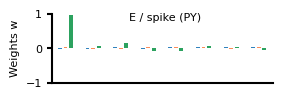

In [825]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.85, 0.9),
        ylabel="Weights w",
        plot_labels=False,
        legend=False,
        title='E / spike (PY)',
        title_x_offset=0,
    )
    plt.savefig(PANEL_E1, facecolor="None", transparent=True)
    plt.show()

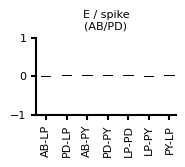

In [826]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-0.3, 0.6], figsize=(1.8, 1.0), ylabel="", color="k", title="E / spike\n(AB/PD)"
    )
    plt.savefig(PANEL_supp_synapses2, facecolor="None", transparent=False)
    plt.show()

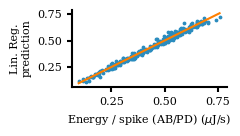

In [827]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300].numpy() * std_energy.numpy() + mean_energy.numpy()
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike (AB/PD) ($\mu$J/s)")
    ax.set_ylabel("Lin. Reg.\nprediction")
    plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

## Number of spikes

In [828]:
# numSpikesPerBurst = x["num_spikes"]["PM"].to_numpy() / x["num_bursts"]["PM"].to_numpy()
# numSpikesPerBurst_test = torch.as_tensor(
#     numSpikesPerBurst[:num_test], dtype=torch.float32
# ).unsqueeze(1)
# numSpikesPerBurst_train = torch.as_tensor(
#     numSpikesPerBurst[num_test:], dtype=torch.float32
# ).unsqueeze(1)

In [829]:
# torch.manual_seed(0)

# sensitivity_num_spikes = ActiveSubspace(posterior.set_default_x(xo))
# converged_nn_num_spikes = sensitivity_num_spikes.add_property(
#     theta_train,
#     numSpikesPerBurst_train,
#     hidden_features=20,
#     num_blocks=1
# ).train()
# e_vals_num_spikes, e_vecs_num_spikes = sensitivity_num_spikes.find_directions()

In [830]:
# predictions = converged_nn_num_spikes(theta_test).detach().numpy()

In [831]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
#     unnorm_x = numSpikesPerBurst_test[:300].numpy()
#     unnorm_y = predictions[:300]
#     ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
#     gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
#     ax.plot(gt_vec, gt_vec, "#ff7f00")
#     ax.set_xlabel("Spikes per burst (AB/PD)")
#     ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

In [832]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.plot_eigenvalues(
#         torch.flip(torch.abs(e_vals_num_spikes), dims=(0,)),
#         figsize=(1.8, 1.0),
#         ylabel="log(E.-value)",
#         color="k",
#         title="Spikes per burst\n(AB/PD)"
#     )
#     print(
#         "Ratio of first to second eigenvalue: ",
#         e_vals_num_spikes[-1] / e_vals_num_spikes[-2],
#     )
#     plt.savefig(PANEL_supp_EV3, facecolor="None", transparent=False)
#     plt.show()

In [833]:
# print("Fraction of first to total: ", e_vals_num_spikes[-1] / torch.sum(e_vals_num_spikes))

In [834]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.py_sensitivity_bars_cosyne(
#         e_vecs_num_spikes[:, -1].T,
#         ylim=[-1, 1.0],
#         figsize=(2.85, 0.9),
#         ylabel="Active dir.",
#         plot_labels=True,
#         legend=True,
#         legend_y_offset=0.3,
#         title='#spikes (AB/PD)',
#         title_x_offset=-0.5,
#         yticks=[-1, 0, 1]
#     )
#     plt.savefig(PANEL_E2, facecolor="None", transparent=True)
#     plt.show()

In [835]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.synapse_sensitivity_bars(
#         e_vecs_num_spikes[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.8, 1.0), ylabel="", color="k", title="Spikes per burst\n(AB/PD)"
#     )
#     plt.savefig(PANEL_supp_synapses3, facecolor="None", transparent=False)
#     plt.show()

### Linear regression

In [836]:
numSpikesPerBurst = x["num_spikes"]["PY"].to_numpy() / x["num_bursts"]["PY"].to_numpy()

In [837]:
numSpikesPerBurst = torch.as_tensor(numSpikesPerBurst)
train_energy_ABPD = numSpikesPerBurst[num_test:].unsqueeze(1)
test_energy_ABPD = numSpikesPerBurst[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

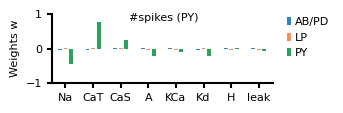

In [838]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.85, 0.9),
        ylabel="Weights w",
        plot_labels=True,
        legend=True,
        legend_y_offset=0.3,
        title='#spikes (PY)',
        title_x_offset=0,
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_E2, facecolor="None", transparent=True)
    plt.show()

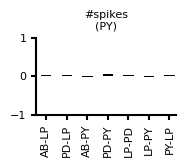

In [839]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-0.3, 0.6], figsize=(1.8, 1.0), ylabel="", color="k", title="#spikes\n(PY)"
    )
    plt.savefig(PANEL_supp_synapses3, facecolor="None", transparent=False)
    plt.show()

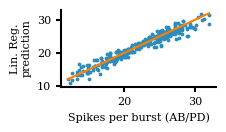

In [840]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300].numpy() * std_energy.numpy() + mean_energy.numpy()
    unnorm_y = predictions[:300] * std_energy.numpy() + mean_energy.numpy()
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst (AB/PD)")
    ax.set_ylabel("Lin. Reg.\nprediction")
    plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

# Relationship between the two

In [841]:
# projected_e_per_spike = sensitivity_e_per_spike.project(theta_train, num_dimensions=1)
# projected_num_spikes = sensitivity_num_spikes.project(theta_train, num_dimensions=1)

In [728]:
# ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike, 0)
# # ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike, 27)

# ind_of_min_numSpikes = nth_argmin(projected_num_spikes, 0)
# # ind_of_max_numSpikes = nth_argmax(projected_num_spikes, 0)

In [729]:
# cond1 = projected_e_per_spike > -1.0
# cond2 = projected_e_per_spike < -0.8
# cond3 = projected_num_spikes > -0.7
# cond4 = projected_num_spikes < -0.6

In [353]:
# full_cond = torch.logical_and(
#     torch.logical_and(torch.logical_and(cond1, cond2), cond3), cond4
# )

In [640]:
# fulfiling_param_sets = theta_train[full_cond[:, 0]]
# print(fulfiling_param_sets.shape)

In [641]:
# parameter_set1 = theta_train[ind_of_min_e_per_spike].unsqueeze(0)
# parameter_set1_dim1 = sensitivity_e_per_spike.project(parameter_set1, num_dimensions=1)
# parameter_set1_dim2 = sensitivity_num_spikes.project(parameter_set1, num_dimensions=1)

# parameter_set2 = theta_train[ind_of_min_numSpikes].unsqueeze(0)
# parameter_set2_dim1 = sensitivity_e_per_spike.project(parameter_set2, num_dimensions=1)
# parameter_set2_dim2 = sensitivity_num_spikes.project(parameter_set2, num_dimensions=1)

# # parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
# parameter_set3 = theta_train[full_cond[:, 0]][2].unsqueeze(0)
# parameter_set3_dim1 = sensitivity_e_per_spike.project(parameter_set3, num_dimensions=1)
# parameter_set3_dim2 = sensitivity_num_spikes.project(parameter_set3, num_dimensions=1)

In [642]:
# energy_PM = x["energies"]["PM"].to_numpy()
# energy_PM_train = energy_PM[num_test:]

In [643]:
# v1 = e_vecs_num_spikes[:, -1]
# v2 = e_vecs_e_per_spike[:, -1]
# norm_v1 = torch.norm(v1)
# dot_prod = torch.dot(v1, v2).item()
# angle = math.acos(dot_prod)
# print("angle in rad:", angle)
# print("angle in deg:", angle / 2 / math.pi * 360)

# angle_within_90deg = math.pi - angle
# my_ticker = ticker.FixedFormatter([-2, 0, 2])

In [644]:
# energy_PM_train.shape

In [645]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     fig = plt.figure(figsize=(3.1, 2.0))
#     viz.curvelinear_test1(
#         fig,
#         angle_within_90deg,
#         projected_num_spikes,
#         projected_e_per_spike,
#         energy_PM_train,
#         parameter_set1_dim1,
#         parameter_set1_dim2,
#         parameter_set2_dim1,
#         parameter_set2_dim2,
#         parameter_set3_dim1,
#         parameter_set3_dim2,
#     )
#     plt.savefig("result_cool.png", dpi=400, bbox_inches="tight")
# #     plt.savefig(PANEL_F1_raw, facecolor="None", transparent=True)
#     plt.show()

### Run simulations

In [646]:
# all_energies_per_spike = x["energies_per_spike"]["PM"].to_numpy()
# all_energies = x["energies"]["PM"].to_numpy()
# all_num_spikes = x["num_spikes"]["PM"].to_numpy()

# min_energy_per_spike = np.min(all_energies_per_spike)
# max_energy_per_spike = np.max(all_energies_per_spike)

# min_energy = np.min(all_energies)
# max_energy = np.max(all_energies)

# min_num_spikes = np.min(all_num_spikes)
# max_num_spikes = np.max(all_num_spikes)

In [647]:
# unnorm_set_dim_1 = pd.DataFrame(parameter_set1[:1], columns=theta.columns)
# unnorm_set_dim_2 = pd.DataFrame(parameter_set2[:1], columns=theta.columns)
# unnorm_set_dim_3 = pd.DataFrame(parameter_set3[:1], columns=theta.columns)

# simulation_output_1 = simulate(
#     unnorm_set_dim_1.loc[0], seed=0, track_energy=True, track_currents=True
# )
# simulation_output_2 = simulate(
#     unnorm_set_dim_2.loc[0], seed=20, track_energy=True, track_currents=True
# )
# simulation_output_3 = simulate(
#     unnorm_set_dim_3.loc[0], seed=0, track_energy=True, track_currents=True
# )

## Plot the traces

In [648]:
# time_vec = np.arange(0, 11000, 0.025)

In [650]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.energy_scape(
#         simulation_output_1,
#         time_vec,
#         (1.3, 1.0),
#         ["k", "k", "k"],
#         time_len=20000,
#         offset=103000,
#         ylimE=[0, 250],
#         v_labelpad=4.7,
#         neuron=0,
#     )
#     plt.savefig(PANEL_G1, facecolor="None", transparent=True)

In [651]:
# summstats = summary_stats(
#     simulation_output_1,
#     stats_customization={
#         "energies": True,
#         "num_spikes": True,
#         "energies_per_spike": True,
#     },
# )
# num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
# energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
# energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.bars_for_energy(
#         num_spikes_ABPD,
#         min_num_spikes,
#         max_num_spikes,
#         energyperspike_ABPD_sim,
#         min_energy_per_spike,
#         max_energy_per_spike,
#         energies_ABPD_sim,
#         min_energy,
#         max_energy,
#     )
#     plt.savefig(PANEL_G2, facecolor="None", transparent=True)
#     plt.show()

In [652]:
# # simulation_output_2 = simulate(
# #     unnorm_set_dim_2.loc[0], seed=20, track_energy=True, track_currents=True
# # )

# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.energy_scape(
#         simulation_output_2,
#         time_vec,
#         (1.3, 1.0),
#         ["k", "k", "k"],
#         time_len=20000,  # 0, 20000, 193000, 20000, 302800
#         offset=167000,
#         ylimE=[0, 250],
#         v_labelpad=4.7,
#         neuron=0,
#     )
#     plt.savefig(PANEL_H1, facecolor="None", transparent=True)

In [653]:
# summstats = summary_stats(
#     simulation_output_2,
#     stats_customization={
#         "energies": True,
#         "num_spikes": True,
#         "energies_per_spike": True,
#     },
# )
# num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
# energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
# energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.bars_for_energy(
#         num_spikes_ABPD,
#         min_num_spikes,
#         max_num_spikes,
#         energyperspike_ABPD_sim,
#         min_energy_per_spike,
#         max_energy_per_spike,
#         energies_ABPD_sim,
#         min_energy,
#         max_energy,
#     )
#     plt.savefig(PANEL_H2, facecolor="None", transparent=True)
#     plt.show()

In [654]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.energy_scape(
#         simulation_output_3,
#         time_vec,
#         (1.3, 1.0),
#         ["k", "k", "k"],
#         time_len=20000,
#         offset=62800,
#         ylimE=[0, 250],
#         v_labelpad=4.7,
#         neuron=0,
#     )
#     plt.savefig(PANEL_I1, facecolor="None", transparent=True)

In [655]:
# summstats = summary_stats(
#     simulation_output_3,
#     stats_customization={
#         "energies": True,
#         "num_spikes": True,
#         "energies_per_spike": True,
#     },
# )
# num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
# energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
# energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.bars_for_energy(
#         num_spikes_ABPD,
#         min_num_spikes,
#         max_num_spikes,
#         energyperspike_ABPD_sim,
#         min_energy_per_spike,
#         max_energy_per_spike,
#         energies_ABPD_sim,
#         min_energy,
#         max_energy,
#     )
#     plt.savefig(PANEL_I2, facecolor="None", transparent=True)
#     plt.show()

## Assemble figure

In [656]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [762]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "9.9cm",

    Panel(
          SVG(PANEL_supp_shift1).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_shift3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(29.5*factor_svg, 0.*factor_svg),
    
    Panel(
          SVG(PANEL_supp_shift4).scale(svg_scale).move(0, 0*factor_svg),
    ).move(55.0*factor_svg, 0.*factor_svg),
    
    Panel(
          SVG(PANEL_supp_shift7).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -3.4*factor_svg, 2.2*factor_svg, **kwargs_text),
    ).move(87.9*factor_svg, 0.3*factor_svg),
           
    Panel(
          SVG(PANEL_NEW_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("c", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 26.5*factor_svg),
    Panel(
        SVG(PANEL_NEW_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -.0*factor_svg, 2.8*factor_svg, **kwargs_text),
    ).move(44.0*factor_svg, 25.2*factor_svg),

    Panel(
        SVG(PANEL_NEW_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(44.0*factor_svg, 45.0*factor_svg),
           
    Panel(
        SVG(PANEL_NEW_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("e", -2.2*factor_svg, 1.7*factor_svg, **kwargs_text),
    ).move(86.7*factor_svg, 26.3*factor_svg),
           
    Panel(
        SVG(PANEL_NEW_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(86.7*factor_svg, 46.0*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_11).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("f", -1.7*factor_svg, 1.7*factor_svg, **kwargs_text),
    ).move(103.7*factor_svg, 26.3*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_12).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(103.7*factor_svg, 46*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_21).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(127.5*factor_svg, 26.3*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_22).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(127.5*factor_svg, 46*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_1.svg")
svg('../fig/fig3_1.svg')

In [770]:
PANEL_MECH_KD_A = "../svg/panel_mech_kd_a_new.svg"
PANEL_MECH_KD_B = "../svg/panel_mech_kd_b_new.svg"
PANEL_MECH_KD_C = "../svg/panel_mech_kd_c_new.svg"
PANEL_MECH_KD_D = "../svg/panel_mech_kd_d_new.svg"
PANEL_MECH_KD_E = "../svg/panel_mech_kd_e_new.svg"
PANEL_MECH_KD_F = "../svg/panel_mech_kd_f_new.svg"
PANEL_MECH_KD_voltage = "../svg/panel_mech_kd_voltage_new.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"

In [772]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "9.3cm",

    Panel(
          SVG(PANEL_lin_reg).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", -5.0*factor_svg, -0.5*factor_svg, **kwargs_text),
    ).move(5*factor_svg, 3*factor_svg),

    Panel(
          SVG(PANEL_B_lin).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -4.0*factor_svg, 1.8*factor_svg, **kwargs_text),
    ).move(46.5*factor_svg, 0.7*factor_svg),
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -1.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(85.0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
          Text("d", -1.5*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(1.5*factor_svg, 27.0*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_D).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", 0*factor_svg, 5.5*factor_svg, **kwargs_text),
    ).move(42*factor_svg, 24.0*factor_svg),

    Panel(
          SVG(PANEL_MECH_KD_B).scale(svg_scale).move(0, 0*factor_svg),
    ).move(42*factor_svg, 42.4*factor_svg),

    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
          Text("f", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(85.0*factor_svg, 28.0*factor_svg),

    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(85*factor_svg, 43.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_2x.svg")
svg('../fig/fig3_2x.svg')

In [765]:
# from svgutils.compose import *

# # > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# # > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
# svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
# factor_svg=5.5

# # Panel letters in Helvetica Neue, 12pt, Medium
# kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
# kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
# kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
# kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
# kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

# f = Figure("20.3cm", "9.6cm",

#     Panel(
#           SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
#           Text("a", -3.5*factor_svg, 2.5*factor_svg, **kwargs_text),
#     ).move(3.5*factor_svg, 0.0*factor_svg),

#     Panel(
#           SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
#           Text("b", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
#     ).move(44.0*factor_svg, 1.0*factor_svg),

#     Panel(
#           SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#     ).move(44*factor_svg, 16.5*factor_svg),

#     Panel(
#           SVG(PANEL_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#         Text("d", 10.7*factor_svg, 9.7*factor_svg, **kwargs_text8pt_blue),
#         Text("e", 26.5*factor_svg, 24.7*factor_svg, **kwargs_text8pt_blue),
#         Text("f", 21.6*factor_svg, 20.6*factor_svg, **kwargs_text8pt_blue),
#         Text("c", -2.0*factor_svg, -.4*factor_svg, **kwargs_text),
#     ).move(92*factor_svg, 3.0*factor_svg),

#     Panel(
#           SVG(PANEL_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#     ).move(92*factor_svg, 25.7*factor_svg),

#     Panel(
#           SVG(PANEL_H1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#         Text("d", -0.5*factor_svg, 0.5*factor_svg, **kwargs_text),
#     ).move(0.5*factor_svg, 150+15.0*factor_svg),

#     Panel(
#           SVG(PANEL_H2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#     ).move(27.5*factor_svg, 150+14.5*factor_svg),

#     Panel(
#           SVG(PANEL_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#         Text("e", -0.5*factor_svg, 0.5*factor_svg, **kwargs_text),
#     ).move(47.0*factor_svg, 150+15*factor_svg),

#     Panel(
#           SVG(PANEL_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#     ).move(74.0*factor_svg, 150+14.5*factor_svg),

#     Panel(
#           SVG(PANEL_I1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#         Text("f", -0.5*factor_svg, 0.5*factor_svg, **kwargs_text),
#     ).move(93.75*factor_svg, 150+15*factor_svg),

#     Panel(
#           SVG(PANEL_I2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
#     ).move(120.5*factor_svg, 150+14.5*factor_svg),
# )

# !mkdir -p fig
# f.save("../fig/fig3_2.svg")
# svg('../fig/fig3_2.svg')

In [766]:
# from svgutils.compose import *

# # > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# # > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
# svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
# factor_svg=5.5

# # Panel letters in Helvetica Neue, 12pt, Medium
# kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
# kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
# kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
# kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
# kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

# f = Figure("20.3cm", "3.0cm",

#     Panel(
#           SVG(PANEL_supp_shift6).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(0*factor_svg, 2.1*factor_svg),

# )

# !mkdir -p fig
# f.save("../fig/fig3_supp7.svg")
# svg('../fig/fig3_supp7.svg')

### Build appendix

In [767]:
# from svgutils.compose import *

# # > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# # > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
# svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
# factor_svg=5.5

# # Panel letters in Helvetica Neue, 12pt, Medium
# kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
# kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
# kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
# kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
# kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
# kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

# f = Figure("20.3cm", "3.7cm",

#     Panel(
#           SVG(PANEL_supp_EV1).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(0*factor_svg, 2.1*factor_svg),
           
#     Panel(
#           SVG(PANEL_supp_EV2).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(40*factor_svg, 0.0*factor_svg),
           
#     Panel(
#           SVG(PANEL_supp_EV3).scale(svg_scale).move(0, 0*factor_svg),
#     ).move(80*factor_svg, 0*factor_svg),
# )

# !mkdir -p fig
# f.save("../fig/fig3_supp2.svg")
# svg('../fig/fig3_supp2.svg')

In [842]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.0cm",

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, -0.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp1.svg")
svg('../fig/fig3_supp1.svg')

In [822]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.8cm",

    Panel(
          SVG(PANEL_supp_synapses1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 2.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(36*factor_svg, 0.*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(69*factor_svg, 0.*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp3.svg")
svg('../fig/fig3_supp3.svg')